<a href="https://colab.research.google.com/github/Parsa-Baniamerian/Human_Activity_Recognition/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random
import datetime as dt
import cv2

In [5]:
# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

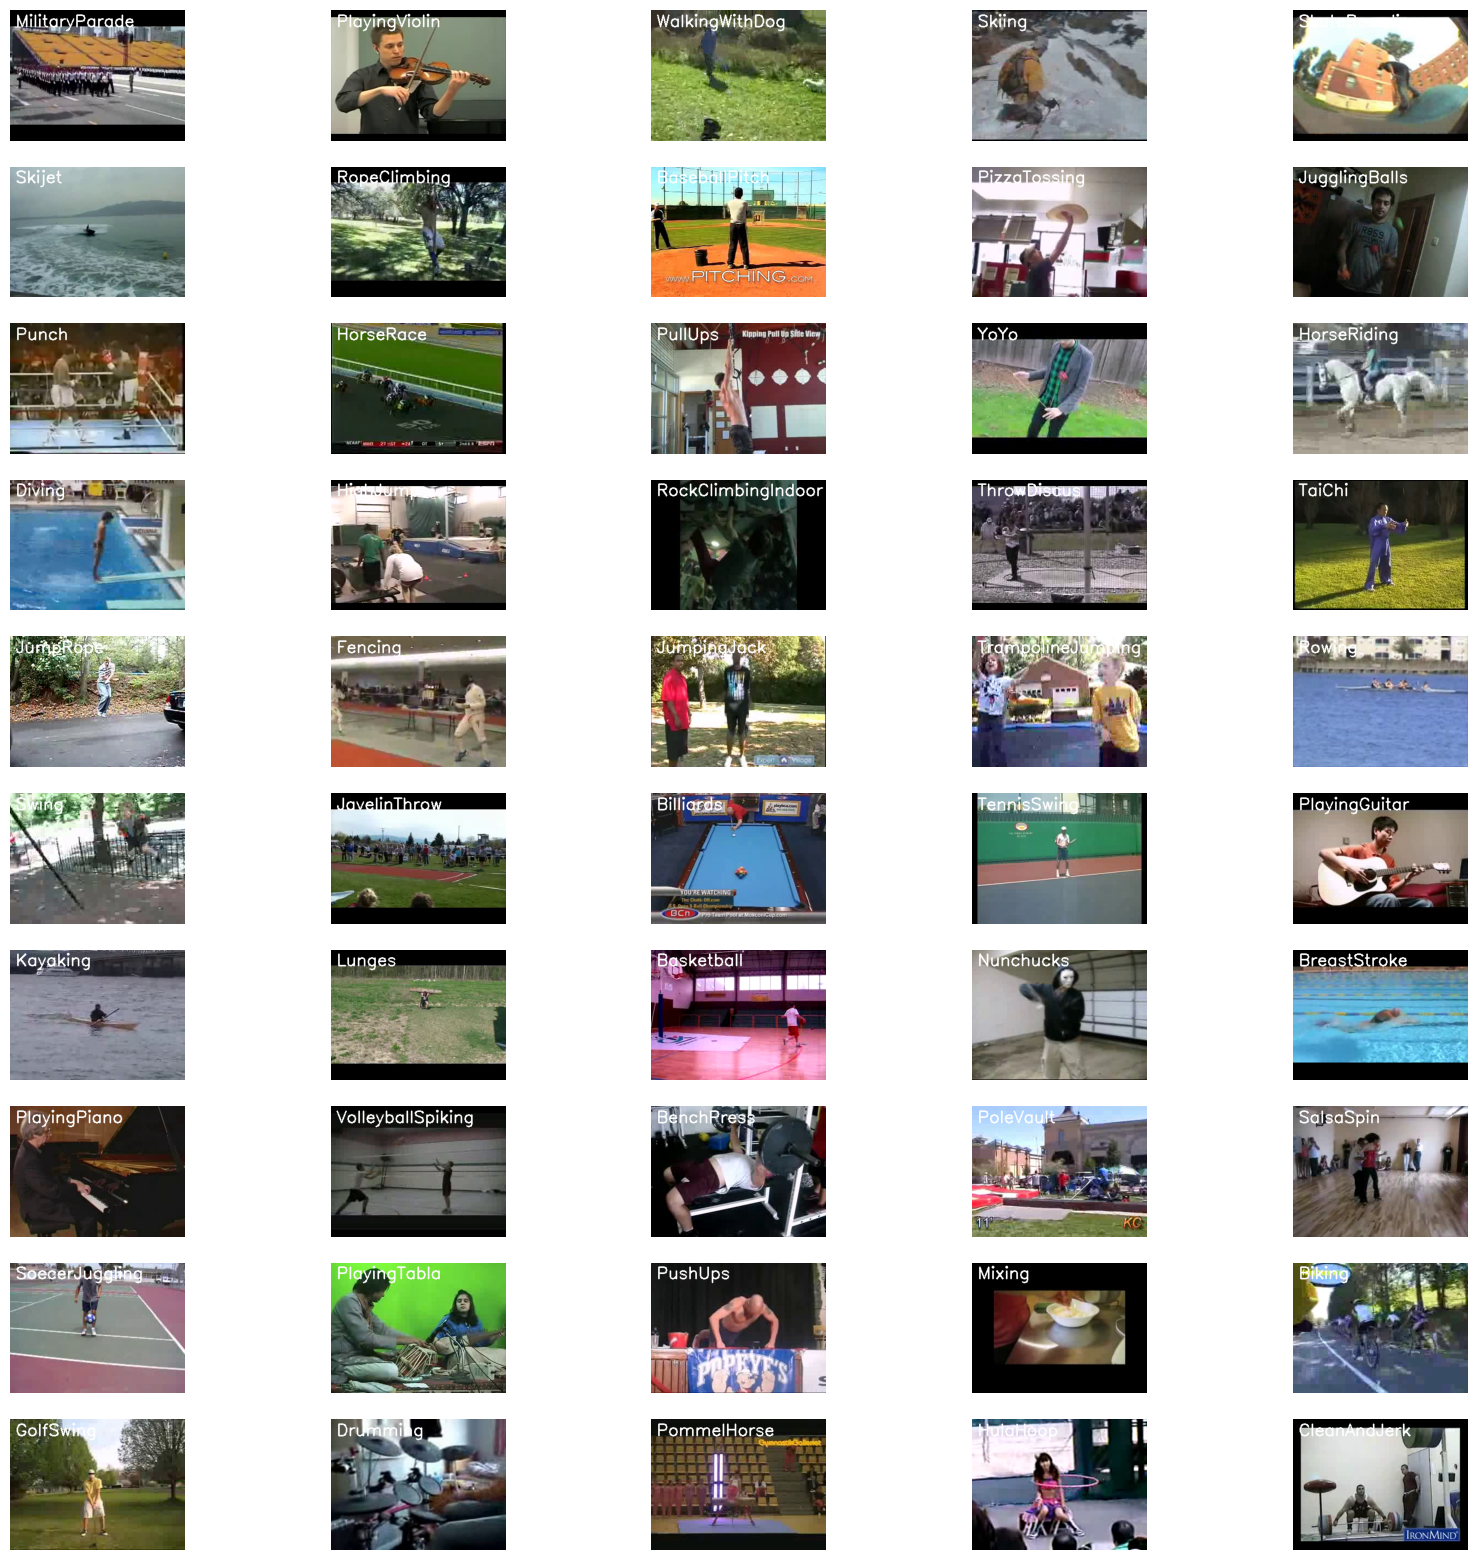

In [18]:
plt.figure(figsize=(20,20))

all_classes_names = os.listdir("UCF50")

for i in range(len(all_classes_names)):
  selected_class_name = all_classes_names[i]

  # Retrieve the list of the all video files present in selected class directory
  video_files_names_list = os.listdir(f"UCF50/{selected_class_name}")

  # Randomly select a video file the list retrieved from the selected class directory
  selected_video_file_name = random.choice(video_files_names_list)

  # Initialize a VideoCapture object to read from the video files
  video_reader = cv2.VideoCapture(f"UCF50/{selected_class_name}/{selected_video_file_name}")

  # Read the first frame of the video files
  _, bgr_frame = video_reader.read()

  # Release the VideoCapture object
  video_reader.release()

  # Cobvert BGR to RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  # Display the frame
  plt.subplot(10, 5, i+1)
  plt.imshow(rgb_frame)
  plt.axis("off")